
# Assignment 1 — Sexism Detection (EXIST 2023 Task 2)

**Group members:** Jacopo Francesco Amoretti, Roberto Frabetti, Ivo Rambaldi

---

## Delivery checklist
- [ ] Task 1 — Corpus (majority vote aggregation, EN filter, label encoding)
- [ ] Task 2 — Data Cleaning (emoji/hashtag/mention/url/symbols/quotes + lemmatization)
- [ ] Task 3 — Text Encoding (GloVe + OOV handling + embedding matrix)
- [ ] Task 4 — Models (BiLSTM baseline and stacked)
- [ ] Task 5 — Training & Evaluation (≥ 3 seeds, macro F1/Prec/Rec, avg ± std)
- [ ] Task 6 — Transformers (Twitter-roBERTa-base-hate + Trainer)
- [ ] Task 7 — Error Analysis (error patterns, confusion/PR, examples)
- [ ] Task 8 — Report (summary of results, figures, metrics table)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## Setup

Run this once at the beginning. It sets seeds, libraries, and project paths.


In [ ]:
train_flag = True

In [ ]:

# === Basic imports ===

import os
import re
import json
import math
import random
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization/plots
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

# Optional: progress bar
try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = lambda x: x

# Seed and device
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)

# Project paths (adjust as needed)
DATA_DIR = Path('data')          # Should contain: train.json, val.json, test.json
GLOVE_DIR = Path('glove')        # Files like glove.6B.100d.txt
ARTIFACTS_DIR = Path('artifacts') # Save vocab, mappings, embedding matrix, etc.
MODELS_DIR = Path('models')
RESULTS_DIR = Path('results')

for d in [ARTIFACTS_DIR, MODELS_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print('Setup complete.')


Setup complete.



# Task 1 — Corpus



In [ ]:

# == Majority vote on a list of labels ==

from collections import Counter

def majority_vote(labels):
    cnt = Counter(labels)
    top = cnt.most_common() # Most frequent labels in descending order
    if len(top) == 0:
        return None, False
    if len(top) > 1 and top[0][1] == top[1][1]:
        return None, False  # If no clear majority
    return top[0][0], True # Return majority label

# Mapping between textual and numerical label representations
label2id = {'-': 0, 'DIRECT': 1, 'JUDGEMENTAL': 2, 'REPORTED': 3}
id2label = {v:k for k,v in label2id.items()}


In [ ]:

# == Load JSON into a DataFrame ==

train_path = Path('data') / 'training.json'
val_path   = Path('data') / 'validation.json'
test_path  = Path('data') / 'test.json'

def loadJson(path: Path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame.from_dict(data, orient='index') # Each key is an index
    return df

# Load raw splits into DataFrames
df_train_raw = loadJson(train_path)
df_val_raw   = loadJson(val_path)
df_test_raw  = loadJson(test_path)

print('Train raw:', df_train_raw.shape, '| Val raw:', df_val_raw.shape, '| Test raw:', df_test_raw.shape)
df_train_raw.head(2) # Display first 2 rows of training data


Train raw: (6920, 11) | Val raw: (726, 11) | Test raw: (312, 11)


,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES


In [ ]:


# == Majority voting on labels_task2 and drop ambiguous labels ==

def apply_majority_and_drop(df):
    mv_labels = []
    keep_mask = []
    for _, row in df.iterrows():
        mv, evaluation = majority_vote(row['labels_task2'])  # Apply majority vote to each row
        mv_labels.append(mv)
        keep_mask.append(evaluation)
    df = df.copy()
    df['label'] = mv_labels  # Add final label column
    df = df[pd.Series(keep_mask).values] # Drop rows without clear majority
    return df

# Apply to all dataset splits
df_train_mv = apply_majority_and_drop(df_train_raw)
df_val_mv   = apply_majority_and_drop(df_val_raw)
df_test_mv  = apply_majority_and_drop(df_test_raw)

print('After adding label column and drop ambiguous labels:',
      'Train:', df_train_mv.shape, 'Val:', df_val_mv.shape, 'Test:', df_test_mv.shape)


After adding label column and drop ambiguous labels: Train: (6065, 12) Val: (630, 12) Test: (280, 12)


In [ ]:

# == EN filter and column selection ==

keep_columns = ['id_EXIST', 'lang', 'tweet', 'label']

def filter_and_select(df):
    df = df[df['lang'] == 'en'].copy()  # Keep only English tweets
    df = df[keep_columns].copy()        # Select relevant columns
    return df

# Apply filtering to all dataset splits
df_train = filter_and_select(df_train_mv)
df_val   = filter_and_select(df_val_mv)
df_test  = filter_and_select(df_test_mv)

print('EN only:', 'Train:', df_train.shape, 'Val:', df_val.shape, 'Test:', df_test.shape)
df_train.head(3)


EN only: Train: (2873, 4) Val: (150, 4) Test: (280, 4)


,id_EXIST,lang,tweet,label
200001,200001,en,FFS! How about laying the blame on the bastard...,-
200002,200002,en,Writing a uni essay in my local pub with a cof...,REPORTED
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,REPORTED


In [ ]:

# == Label encoding ==

def encode_labels(df):
    df = df.copy()
    df['label_id'] = df['label'].map(label2id)  # Convert text labels to numeric IDs
    return df

# Apply label encoding to all dataset splits
df_train = encode_labels(df_train)
df_val   = encode_labels(df_val)
df_test  = encode_labels(df_test)

print(df_train['label'].value_counts())  # Check label distribution
df_train.head(3)     # Inspect encoded DataFrame


label
-              2014
DIRECT          537
REPORTED        184
JUDGEMENTAL     138
Name: count, dtype: int64


,id_EXIST,lang,tweet,label,label_id
200001,200001,en,FFS! How about laying the blame on the bastard...,-,0
200002,200002,en,Writing a uni essay in my local pub with a cof...,REPORTED,3
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,REPORTED,3


In [ ]:

# == Save post-Task1 datasets for quick reuse ==

df_train[['id_EXIST','lang','tweet','label','label_id']].to_csv('results/train_task1.csv', index=False)
df_val[['id_EXIST','lang','tweet','label','label_id']].to_csv('results/val_task1.csv', index=False)
df_test[['id_EXIST','lang','tweet','label','label_id']].to_csv('results/test_task1.csv', index=False)
print("Saved post-Task1 datasets to 'results/' directory.")

Saved post-Task1 datasets to 'results/' directory.



# Task 2 — Data Cleaning



In [ ]:

# == Text cleaning: basic regex ==

import re

URL = re.compile(r'https?://\S+|www\.\S+') # Match URLs
MENTION = re.compile(r'@\w+') # Match @ symbol
HASHTAG = re.compile(r'#\w+') # Match hashtags
EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE) # Match emojis
SPECIAL_QUOTES_REPLACEMENTS = { # Special quotes to normal quotes
    '“': '"', '”': '"', '‘': "'", '’': "'",
    '«': '"', '»': '"', '…': '...'
}

def normalize_quotes(text: str):
    for k, v in SPECIAL_QUOTES_REPLACEMENTS.items():
        text = text.replace(k, v)
    return text

def basic_clean(text: str):
    text = normalize_quotes(text)                           # Standardize quotes
    text = URL.sub(' ', text)                               # Remove URLs
    text = MENTION.sub(' ', text)                           # Remove mentions
    text = HASHTAG.sub(' ', text)                           # Remove hashtags
    text = EMOJI.sub(' ', text)                             # Remove emojis
    text = re.sub(r"[^0-9A-Za-z'\.,!\?\s]", ' ', text)      # Remove unwanted symbols
    text = re.sub(r'\s+', ' ', text).strip()                # Normalize spaces
    return text

print(basic_clean("Check this: https:/try.com @user #hashtag 👍🏻 “quote” — symbols")) # Check the function correctness


Check this https try.com quote symbols


In [ ]:

# == Lemmatization with spaCy ==

USE_SPACY = True

# Load spaCy model and verify if it's available
try:
    import spacy
    try:
        nlp = spacy.load('en_core_web_sm', disable=['ner'])  # Load lightweight English model
    except Exception:
        nlp = None
        print("Warning: spaCy model 'en_core_web_sm' not installed. Install it and re-run.")
except Exception:
    USE_SPACY = False
    nlp = None
    print('spaCy not available; skipping lemmatization or use another library.')

def lemmatize_en(texts):
    if nlp is None:
        return texts    # Skip if model not available
    docs = nlp.pipe(texts, batch_size=512) # Process texts in batches for efficiency
    out = []
    for doc in docs:
        lemmas = [t.lemma_.lower() for t in doc if not t.is_space] # Creating lemmas list
        out.append(' '.join(lemmas))
    return out

def apply_clean_and_lemma(df, text_col='tweet'):
    df = df.copy()
    df['clean'] = df[text_col].astype(str).apply(basic_clean)    # Apply regex-based cleaning
    df['clean_lemma'] = lemmatize_en(df['clean'].tolist())  # Lemmatize cleaned text
    return df

# Apply cleaning and lemmatization to all splits
df_train = apply_clean_and_lemma(df_train, 'tweet')
df_val   = apply_clean_and_lemma(df_val, 'tweet')
df_test  = apply_clean_and_lemma(df_test, 'tweet')

df_train[['tweet','clean','clean_lemma']].head(3)   # Inspect transformation results


,tweet,clean,clean_lemma
200001,FFS! How about laying the blame on the bastard...,FFS! How about laying the blame on the bastard...,ffs ! how about lay the blame on the bastard w...
200002,Writing a uni essay in my local pub with a cof...,Writing a uni essay in my local pub with a cof...,write a uni essay in my local pub with a coffe...
200003,@UniversalORL it is 2021 not 1921. I dont appr...,it is 2021 not 1921. I dont appreciate that on...,it be 2021 not 1921 . i do not appreciate that...



# Task 3 — Text Encoding



In [ ]:
TOKEN_RE = re.compile(r"\w+(?:'\w+)?") # Basic regex tokenizer (keeps apostrophes within words)

def simple_tokenize(text):
    return TOKEN_RE.findall(str(text).lower())  # Tokenize and lowercase text

def build_vocab_from_train(texts, min_freq=1):
    from collections import Counter
    c = Counter()
    for t in texts:
        for tok in simple_tokenize(t):
            c[tok] += 1 # Count token frequency
    vocab = {tok for tok, f in c.items() if f >= min_freq}  # Keep tokens above frequency threshold
    return vocab, c

# Build vocabulary from training texts
train_texts = df_train['clean_lemma'] if 'clean_lemma' in df_train.columns else df_train['clean']
vocab_set, freq = build_vocab_from_train(train_texts.tolist(), min_freq=1)

print('Vocab size (train):', len(vocab_set))

# Display top 20 most frequent tokens
from collections import Counter
tokens = [tok for t in train_texts for tok in simple_tokenize(t)]
Counter(tokens).most_common(20)

Vocab size (train): 9073


[('be', 3793),
 ('the', 2648),
 ('to', 1998),
 ('i', 1992),
 ('a', 1915),
 ('and', 1657),
 ('of', 1393),
 ('not', 1313),
 ('you', 1115),
 ('it', 984),
 ('that', 917),
 ('do', 906),
 ('in', 894),
 ('have', 780),
 ('woman', 755),
 ('for', 728),
 ('they', 558),
 ('this', 546),
 ('on', 535),
 ('like', 515)]

In [ ]:

# == Download and load GloVe (Twitter 27B) ==

import os, pathlib, zipfile, urllib.request

EMB_DIM = 100
GLOVE_DIR = pathlib.Path("glove")
GLOVE_DIR.mkdir(parents=True, exist_ok=True)
GLOVE_FILE = GLOVE_DIR / f"glove.twitter.27B.{EMB_DIM}d.txt"

# Download and extract GloVe embeddings if not already present
if not GLOVE_FILE.exists():
    url = "https://nlp.stanford.edu/data/glove.twitter.27B.zip"
    zip_path = GLOVE_DIR / "glove.twitter.27B.zip"
    print("Downloading:", url)
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path) as zf:
        zf.extract(GLOVE_FILE.name, GLOVE_DIR)
    os.remove(zip_path)
print("GloVe ready at:", GLOVE_FILE)


GLOVE_FILE = Path('glove') / f'glove.twitter.27B.{EMB_DIM}d.txt'

def load_glove(path):
    emb = {}
    if not path.exists():
        print(f'WARNING: GloVe file not found: {path}. Will initialize OOV randomly.')
        return emb
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.rstrip().split(' ')
            w = parts[0]
            vec = np.asarray(parts[1:], dtype=np.float32)   # Convert embedding values to float array
            emb[w] = vec
    print('Loaded GloVe vectors:', len(emb))
    return emb


# Load pre-trained embeddings into dictionary
glove = load_glove(GLOVE_FILE)


Downloading: https://nlp.stanford.edu/data/glove.twitter.27B.zip
GloVe ready at: glove/glove.twitter.27B.100d.txt
Loaded GloVe vectors: 1193514


In [ ]:

# == Build embedding matrix and save artifacts ==

SPECIAL_TOKENS = ['<PAD>', '<UNK>']
token_list = sorted(vocab_set)

itos = SPECIAL_TOKENS + token_list  # Index → token mapping
stoi = {tok:i for i, tok in enumerate(itos)}    # Token → index mapping

def rand_vec(d):
    return np.random.normal(0, 0.1, size=(d,)).astype(np.float32)   # Random vector for OOV tokens

# Initialize embedding matrix
embedding_matrix = np.zeros((len(itos), EMB_DIM), dtype=np.float32)
embedding_matrix[stoi['<PAD>']] = np.zeros(EMB_DIM, dtype=np.float32)
embedding_matrix[stoi['<UNK>']] = rand_vec(EMB_DIM)


# Fill embedding matrix using GloVe, random for OOV tokens
oov_count = 0
for tok in token_list:
    idx = stoi[tok]
    if tok in glove:
        embedding_matrix[idx] = glove[tok]
    else:
        embedding_matrix[idx] = rand_vec(EMB_DIM)
        oov_count += 1

print('Total vocab:', len(itos), '| OOV (train vs GloVe):', oov_count)

# Save embeddings and vocabulary files for reuse
np.save(Path('artifacts') / 'embedding_matrix.npy', embedding_matrix)
import pandas as pd
pd.Series(itos).to_csv(Path('artifacts') / 'itos.csv', index=False)
pd.Series(stoi).to_csv(Path('artifacts') / 'stoi.csv')
print('Saved embedding_matrix.npy, itos.csv, stoi.csv to artifacts/')

Total vocab: 9075 | OOV (train vs GloVe): 1067
Saved embedding_matrix.npy, itos.csv, stoi.csv to artifacts/


In [ ]:

# == Encode text into token IDs ==

MAX_LEN = 64
PAD_ID = stoi['<PAD>']
UNK_ID = stoi['<UNK>']

def encode_text(text, max_len=MAX_LEN):
    toks = simple_tokenize(text)
    ids = [stoi.get(t, UNK_ID) for t in toks]    # Convert tokens to IDs, use UNK_ID for unseen tokens
    if len(ids) < max_len:
        ids = ids + [PAD_ID] * (max_len - len(ids)) # Pad shorter sequences
    else:
        ids = ids[:max_len] # Truncate longer sequences
    return ids

def encode_dataframe(df, text_col='clean_lemma'):
    X = np.vstack([encode_text(t) for t in df[text_col].tolist()])  # Encode all texts
    y = df['label_id'].values.astype(int)
    return X, y

# Encode datasets into numeric form
X_train, y_train = encode_dataframe(df_train)
X_val,   y_val   = encode_dataframe(df_val)
X_test,  y_test  = encode_dataframe(df_test)

X_train.shape, X_val.shape, X_test.shape  # Check encoded matrix dimensions


((2873, 64), (150, 64), (280, 64))


# Task 4 — Model Definition (BiLSTM)



In [ ]:


# == Define baseline and stacked BiLSTM models ==

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

NUM_CLASSES = 4
EMBED_TRAINABLE = True

def build_baseline_bilstm(vocab_size, emb_dim, embedding_matrix, max_len=64):
    inp = layers.Input(shape=(max_len,), name='input_ids')
    emb = layers.Embedding(input_dim=vocab_size,
                           output_dim=emb_dim,
                           weights=[embedding_matrix],
                           trainable=EMBED_TRAINABLE,
                           mask_zero=True,        # Ignore padding tokens
                           name='encoder_embedding')(inp)
    x = layers.Bidirectional(layers.LSTM(128))(emb)     # BiLSTM encoder
    x = layers.Dropout(0.2)(x)                          # Regularization
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)    # Class probabilities
    model = models.Model(inp, out, name='bilstm_baseline')
    return model

def build_stacked_bilstm(vocab_size, emb_dim, embedding_matrix, max_len=64):
    inp = layers.Input(shape=(max_len,), name='input_ids')
    emb = layers.Embedding(input_dim=vocab_size,
                           output_dim=emb_dim,
                           weights=[embedding_matrix],
                           trainable=EMBED_TRAINABLE,
                           mask_zero=True,
                           name='encoder_embedding')(inp)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(emb)   # First BiLSTM returns sequence
    x = layers.Bidirectional(layers.LSTM(64))(x)                             # Second BiLSTM compresses it
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = models.Model(inp, out, name='bilstm_stacked')
    return model

VOCAB_SIZE = embedding_matrix.shape[0]
EMB_DIM = embedding_matrix.shape[1] # In our case 100

# Instantiate models
baseline = build_baseline_bilstm(VOCAB_SIZE, EMB_DIM, embedding_matrix, MAX_LEN)
stacked  = build_stacked_bilstm(VOCAB_SIZE, EMB_DIM, embedding_matrix, MAX_LEN)

baseline.summary()


Model: "bilstm_baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 64, 100)   │    907,500 │ input_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 64)        │          0 │ input_ids[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    234,496 │ encoder_embeddin… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │      1,028 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,143,024 (4.36 MB)

 Trainable params: 1,143,024 (4.36 MB)

 Non-trainable params: 0 (0.00 B)


# Task 5 — Training & Evaluation



In [ ]:

# == Train across multiple seeds and evaluate on validation ==

from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

import os

model_name = "baseline_bilstm"   # fixed for this model
model_dir = os.path.join("weights", model_name)

os.makedirs(model_dir, exist_ok=True)

def train_and_eval(model_fn, X_tr, y_tr, X_va, y_va, seeds=[1337, 2025, 42], epochs=10, batch_size=64):
    histories = []
    scores = []
    for s in seeds:
        tf.keras.utils.set_random_seed(s)        # Ensure reproducibility per run
        model = model_fn(VOCAB_SIZE, EMB_DIM, embedding_matrix, MAX_LEN)
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        # Add EarlyStopping to monitor val_loss and stop if no improvement
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

        h = model.fit(X_tr, y_tr, validation_data=(X_va, y_va),
                      epochs=epochs, batch_size=batch_size, verbose=1,
                      callbacks=[early_stopping])
        histories.append(h.history)                         # Keep training curves
        y_pred = np.argmax(model.predict(X_va), axis=1)     # Predicted class ids

        # Macro metrics: average per-class
        prec, rec, f1, _ = precision_recall_fscore_support(y_va, y_pred, average='macro', zero_division=0)
        scores.append({'seed': s, 'precision': prec, 'recall': rec, 'f1': f1})
        weights_path = os.path.join(model_dir, f"{s}.weights.h5")   # s = seed
        model.save_weights(weights_path)

    return histories, pd.DataFrame(scores)

In [ ]:

# == Train and evaluate baseline BiLSTM ==

if train_flag:

  hist_base, df_scores_base = train_and_eval(
      build_baseline_bilstm,
      X_train, y_train,
      X_val, y_val
  )

#if the flag is set to false tries to load the weights, if it fails trains the model and saves the weights
if not train_flag:
  #load weight and compute scores
  try:
    if not model_dir.exists(): #check if weight  directory exists
        raise FileNotFoundError(f"{model_dir} does not exist")
    df_scores_base = []

    for weight_path in sorted(model_dir.glob("*.weights.h5")):   #load all weights sets and compute metrics
      # Filename without extension is the seed, e.g. "1337" -> 1337
      seed = int(weight_path.stem)

      # Build fresh model and load weights
      model = build_baseline_bilstm(VOCAB_SIZE, EMB_DIM, embedding_matrix, MAX_LEN)
      model.load_weights(weight_path)

      # Compute scores on validation set
      y_pred = np.argmax(model.predict(X_val), axis=1)
      prec, rec, f1, _ = precision_recall_fscore_support(
          y_val, y_pred, average='macro', zero_division=0
      )
      df_scores_base.append({'seed': seed, 'precision': prec, 'recall': rec, 'f1': f1})

  except Exception as e : #if error occurs train
    print("Following error occured, will train model from scratch, : ", e)

    hist_base, df_scores_base = train_and_eval(
        build_baseline_bilstm,
        X_train, y_train,
        X_val, y_val
    )



Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6925 - loss: 0.9256 - val_accuracy: 0.7000 - val_loss: 0.8167
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7383 - loss: 0.7463 - val_accuracy: 0.7533 - val_loss: 0.7080
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7671 - loss: 0.6255 - val_accuracy: 0.7600 - val_loss: 0.6724
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7912 - loss: 0.5419 - val_accuracy: 0.7600 - val_loss: 0.7080
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8258 - loss: 0.4668 - val_accuracy: 0.7600 - val_loss: 0.6907
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8582 - loss: 0.3846 - val_accuracy: 0.7400 - val_loss: 0.7102
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6713 - loss: 0.9312 - val_accuracy: 0.7000 - val_los

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7023 - loss: 0.9183 - val_accuracy: 0.7200 - val_loss: 0.8101
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7366 - loss: 0.7371 - val_accuracy: 0.7200 - val_loss: 0.7432
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7661 - loss: 0.6307 - val_accuracy: 0.7600 - val_loss: 0.6930
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8048 - loss: 0.5291 - val_accuracy: 0.7533 - val_loss: 0.6676
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8495 - loss: 0.4233 - val_accuracy: 0.7467 - val_loss: 0.7151
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8968 - loss: 0.3034 - val_accuracy: 0.7467 - val_loss: 0.8373
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9162 - loss: 0.2384 - val_accuracy: 0.7467 - val_loss: 0.8960
Epoch 7: early stopping
Restoring model weights from the end of the best 

In [ ]:

# == Display results for Baseline BiLSTM ==

print("=== Baseline BiLSTM Validation Results ===\n")
print(df_scores_base.round(3))  # Per-seed table (unchanged)

print("\n--- Average and Std per Metric over Seeds ---")
metrics = ['precision', 'recall', 'f1']
for m in metrics:
    avg = df_scores_base[m].mean()
    std = df_scores_base[m].std()
    print(f"{m.capitalize()}: {avg:.3f} ± {std:.3f}")

=== Baseline BiLSTM Validation Results ===

   seed  precision  recall     f1
0  1337      0.504   0.385  0.400
1  2025      0.478   0.441  0.453
2    42      0.508   0.408  0.418

--- Average and Std per Metric over Seeds ---
Precision: 0.496 ± 0.016
Recall: 0.411 ± 0.028
F1: 0.424 ± 0.027


In [ ]:


# == Train and evaluate stacked BiLSTM ==

model_name = "stacked_bilstm"   # fixed for this model
model_dir = os.path.join("weights", model_name)

os.makedirs(model_dir, exist_ok=True)


if train_flag:

  hist_base, df_scores_stacked = train_and_eval(
      build_baseline_bilstm,
      X_train, y_train,
      X_val, y_val
  )

#if the flag is set to false tries to load the weights, if it fails trains the model and saves the weights
if not train_flag:
  #load weight and compute scores
  try:
    if not model_dir.exists(): #check if weight  directory exists
        raise FileNotFoundError(f"{model_dir} does not exist")
    df_scores_stacked = []

    for weight_path in sorted(model_dir.glob("*.weights.h5")):   #load all weights sets and compute metrics
      # Filename without extension is the seed, e.g. "1337" -> 1337
      seed = int(weight_path.stem)

      # Build fresh model and load weights
      model =  build_stacked_bilstm(VOCAB_SIZE, EMB_DIM, embedding_matrix, MAX_LEN)
      model.load_weights(weight_path)

      # Compute scores on validation set
      y_pred = np.argmax(model.predict(X_val), axis=1)
      prec, rec, f1, _ = precision_recall_fscore_support(
          y_val, y_pred, average='macro', zero_division=0
      )
      df_scores_stacked.append({'seed': seed, 'precision': prec, 'recall': rec, 'f1': f1})

  except Exception as e : #if error occurs train
    print("Following error occured, will train model from scratch, : ", e)

    hist_base, df_scores_stacked = train_and_eval(
        build_stacked_bilstm,
        X_train, y_train,
        X_val, y_val
    )


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6925 - loss: 0.9256 - val_accuracy: 0.7000 - val_loss: 0.8167
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7383 - loss: 0.7463 - val_accuracy: 0.7533 - val_loss: 0.7080
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7671 - loss: 0.6254 - val_accuracy: 0.7600 - val_loss: 0.6725
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7912 - loss: 0.5419 - val_accuracy: 0.7600 - val_loss: 0.7080
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8258 - loss: 0.4669 - val_accuracy: 0.7600 - val_loss: 0.6907
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8583 - loss: 0.3846 - val_accuracy: 0.7400 - val_loss: 0.7103
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6713 - loss: 0.9312 - val_accuracy: 0.7000 - val_los

In [ ]:

# == Display results for Stacked BiLSTM ==

print("\n\n=== Stacked BiLSTM Validation Results ===\n")
print(df_scores_stacked.round(3))

print("\n--- Average and Std per Metric over Seeds ---")
metrics = ['precision', 'recall', 'f1']
for m in metrics:
    avg = df_scores_stacked[m].mean()
    std = df_scores_stacked[m].std()
    print(f"{m.capitalize()}: {avg:.3f} ± {std:.3f}")



=== Stacked BiLSTM Validation Results ===

   seed  precision  recall     f1
0  1337      0.504   0.385  0.400
1  2025      0.478   0.441  0.453
2    42      0.508   0.408  0.418

--- Average and Std per Metric over Seeds ---
Precision: 0.496 ± 0.016
Recall: 0.411 ± 0.028
F1: 0.424 ± 0.027


In [ ]:

def evaluate_predictions(y_true, y_pred, labels_map=id2label):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    df_rep = pd.DataFrame(report).T
    cm = confusion_matrix(y_true, y_pred, labels=sorted(labels_map.keys()))
    return df_rep, cm

def plot_confusion_matrix(cm, labels):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center')
    plt.tight_layout()
    plt.show()



# Task 6 — Transformers (Twitter-roBERTa-base-hate)

Model: **cardiffnlp/twitter-roberta-base-hate**  
- Tokenize with HF tokenizer, prepare `Dataset`, use `Trainer` with macro F1, evaluate on test.


In [ ]:
# === Task 6 – Transformers (Twitter-roBERTa-base-hate) with multiple seeds ===

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import random
import torch
import pandas as pd

if torch.cuda.is_available():
    device = torch.device("cuda")      # for training on colab
else:
    device = torch.device("cpu")


MODEL_NAME = "cardiffnlp/twitter-roberta-base-hate"
HF_MAX_LEN = 64  # keep comparable with previous models

# Use same SEEDS as in previous tasks if already defined, otherwise fall back
SEEDS = globals().get("SEEDS", [42, 1337, 2025])

from pathlib import Path

TRAIN_FLAG = True   # True = train and save; False = load and evaluate only

WEIGHTS_DIR = Path("weights")
ROBERTA_WEIGHTS_DIR = WEIGHTS_DIR / "roberta"
ROBERTA_WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)

print("RoBERTa weights will be stored in:", ROBERTA_WEIGHTS_DIR)

def set_all_seeds(seed: int):
    """Set all relevant RNG seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# --- Prepare HF Datasets (done once, reused across seeds) ---

df_train_hf = df_train.reset_index(drop=True)
df_val_hf   = df_val.reset_index(drop=True)
df_test_hf  = df_test.reset_index(drop=True)


def to_hf_dataset(df, text_col="clean_lemma"):
    """
    Convert pandas DataFrame to HF Dataset with columns: 'text' and 'label'.
    Assumes a 'label_id' column is present.
    """
    return Dataset.from_pandas(
        df[[text_col, "label_id"]].rename(columns={text_col: "text", "label_id": "label"}),
        preserve_index=False,
    )


ds_train = to_hf_dataset(df_train_hf)
ds_val   = to_hf_dataset(df_val_hf)
ds_test  = to_hf_dataset(df_test_hf)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


def tokenize_fn(batch):
    """Tokenize a batch of texts."""
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=HF_MAX_LEN,
    )


ds_train = ds_train.map(tokenize_fn, batched=True)
ds_val   = ds_val.map(tokenize_fn, batched=True)
ds_test  = ds_test.map(tokenize_fn, batched=True)

# Remove raw text, keep tokenized tensors + labels
ds_train = ds_train.remove_columns(["text"])
ds_val   = ds_val.remove_columns(["text"])
ds_test  = ds_test.remove_columns(["text"])

ds_train.set_format("torch")
ds_val.set_format("torch")
ds_test.set_format("torch")


def compute_metrics(eval_pred):
    """
    Compute macro precision/recall/F1 for Trainer.
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    return {
        "macro_precision": prec,
        "macro_recall": rec,
        "macro_f1": f1,
    }

def train_roberta_multi_seed( #in this case i integrated the saving/loading directly into the function
    ds_train,
    ds_val,
    ds_test,
    seeds=SEEDS,
):
    """
    Train or load Twitter-RoBERTa across multiple seeds and evaluate on val + test.

    If TRAIN_FLAG is True:
        - train one model per seed
        - save each model under weights/roberta/seed_<seed>/
    If TRAIN_FLAG is False:
        - load each model from weights/roberta/seed_<seed>/
        - evaluate on val + test
    """
    seed_results = []
    val_preds_by_seed = {}
    test_preds_by_seed = {}

    for seed in seeds:
        print(f"\n========== Twitter-roBERTa (seed={seed}) ==========")
        set_all_seeds(seed)

        # Directory for this seed
        seed_dir = ROBERTA_WEIGHTS_DIR / f"seed_{seed}"
        seed_dir_str = str(seed_dir)

        if TRAIN_FLAG:
            # Fresh model for each seed
            model = AutoModelForSequenceClassification.from_pretrained(
                MODEL_NAME,
                num_labels=len(label2id),
                id2label=id2label,
                label2id=label2id,
                ignore_mismatched_sizes=True,
            )
            model.to(device)

            # TrainingArguments per seed (different output_dir to avoid clashes)
            training_args = TrainingArguments(
                output_dir=str(MODELS_DIR / f"twitter-roberta-base-hate-seed{seed}"),
                eval_strategy="epoch",           # your version uses eval_strategy
                save_strategy="epoch",
                learning_rate=2e-5,
                per_device_train_batch_size=16,
                per_device_eval_batch_size=32,
                num_train_epochs=3,
                weight_decay=0.01,
                load_best_model_at_end=True,
                metric_for_best_model="macro_f1",
                logging_steps=50,
                seed=seed,
            )

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=ds_train,
                eval_dataset=ds_val,
                compute_metrics=compute_metrics,
            )

            print(f"[seed {seed}] Training...")
            trainer.train()

            # Save model + tokenizer for this seed
            seed_dir.mkdir(parents=True, exist_ok=True)
            trainer.save_model(seed_dir_str)
            tokenizer.save_pretrained(seed_dir_str)
            print(f"[seed {seed}] Saved model to {seed_dir_str}")

        else:
            # Load model + tokenizer from disk
            print(f"[seed {seed}] Loading model from {seed_dir_str}")
            model = AutoModelForSequenceClassification.from_pretrained(
                seed_dir_str,
                num_labels=len(label2id),
                id2label=id2label,
                label2id=label2id,
            )
            model.to(device)

            # You can reuse the same TrainingArguments; we won't call train()
            training_args = TrainingArguments(
                output_dir=str(MODELS_DIR / f"twitter-roberta-loaded-seed{seed}"),
                per_device_eval_batch_size=32,
                do_train=False,
                do_eval=True,
                seed=seed,
            )

            trainer = Trainer(
                model=model,
                args=training_args,
                eval_dataset=ds_val,
                compute_metrics=compute_metrics,
            )

        # --- Evaluate on validation and test ---
        eval_val = trainer.evaluate(ds_val)
        eval_test = trainer.evaluate(ds_test)

        seed_results.append({
            "seed": seed,
            "val_loss": eval_val.get("eval_loss"),
            "val_macro_precision": eval_val.get("eval_macro_precision"),
            "val_macro_recall": eval_val.get("eval_macro_recall"),
            "val_macro_f1": eval_val.get("eval_macro_f1"),
            "test_loss": eval_test.get("eval_loss"),
            "test_macro_precision": eval_test.get("eval_macro_precision"),
            "test_macro_recall": eval_test.get("eval_macro_recall"),
            "test_macro_f1": eval_test.get("eval_macro_f1"),
        })

        # Predictions for error analysis
        pred_val = trainer.predict(ds_val)
        pred_test = trainer.predict(ds_test)

        y_val_hf = pred_val.label_ids
        y_pred_val_hf = np.argmax(pred_val.predictions, axis=-1)

        y_test_hf = pred_test.label_ids
        y_pred_test_hf = np.argmax(pred_test.predictions, axis=-1)

        val_preds_by_seed[seed] = {
            "y_true": y_val_hf,
            "y_pred": y_pred_val_hf,
        }
        test_preds_by_seed[seed] = {
            "y_true": y_test_hf,
            "y_pred": y_pred_test_hf,
        }

    df_roberta_seeds = pd.DataFrame(seed_results)
    return df_roberta_seeds, val_preds_by_seed, test_preds_by_seed


RoBERTa weights will be stored in: weights/roberta


Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

In [ ]:
# === Run Task 6 (train or load depending on TRAIN_FLAG) ===

df_roberta_seeds, val_preds_by_seed, test_preds_by_seed = train_roberta_multi_seed(
    ds_train,
    ds_val,
    ds_test,
    seeds=SEEDS,
)

display(df_roberta_seeds)

print("\n=== Twitter-roBERTa – mean/stdev across seeds (validation) ===")
print(df_roberta_seeds[[
    "val_macro_precision",
    "val_macro_recall",
    "val_macro_f1"
]].agg(["mean", "std"]))

print("\n=== Twitter-roBERTa – mean/stdev across seeds (test) ===")
print(df_roberta_seeds[[
    "test_macro_precision",
    "test_macro_recall",
    "test_macro_f1"
]].agg(["mean", "std"]))

df_roberta_seeds.to_csv(RESULTS_DIR / "twitter_roberta_multi_seed_results.csv", index=False)
np.save(RESULTS_DIR / "twitter_roberta_val_preds_by_seed.npy", val_preds_by_seed, allow_pickle=True)
np.save(RESULTS_DIR / "twitter_roberta_test_preds_by_seed.npy", test_preds_by_seed, allow_pickle=True)

BEST_SEED = df_roberta_seeds.sort_values("val_macro_f1", ascending=False)["seed"].iloc[0]
print(f"\nUsing seed={BEST_SEED} for detailed error analysis in Task 7.")

y_val_hf = val_preds_by_seed[BEST_SEED]["y_true"]
y_pred_val_hf = val_preds_by_seed[BEST_SEED]["y_pred"]
y_test_hf = test_preds_by_seed[BEST_SEED]["y_true"]
y_pred_test_hf = test_preds_by_seed[BEST_SEED]["y_pred"]



========== Twitter-roBERTa (seed=42) ==========


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[seed 42] Training...


Epoch,Training Loss,Validation Loss,Macro Precision,Macro Recall,Macro F1
1,0.639200,0.603343,0.504315,0.463639,0.464511
2,0.513100,0.604873,0.468662,0.499068,0.478227
3,0.407700,0.623628,0.763839,0.539700,0.548640


[seed 42] Saved model to weights/roberta/seed_42



========== Twitter-roBERTa (seed=123) ==========


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[seed 123] Training...


Epoch,Training Loss,Validation Loss,Macro Precision,Macro Recall,Macro F1
1,0.683900,0.602418,0.339441,0.426605,0.375627
2,0.526100,0.579572,0.494177,0.485378,0.477273
3,0.388600,0.616558,0.532245,0.503830,0.501637


[seed 123] Saved model to weights/roberta/seed_123



========== Twitter-roBERTa (seed=2024) ==========


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[seed 2024] Training...


Epoch,Training Loss,Validation Loss,Macro Precision,Macro Recall,Macro F1
1,0.671100,0.591131,0.333856,0.398758,0.363257
2,0.505300,0.613106,0.873162,0.549094,0.555472
3,0.408200,0.630278,0.774465,0.532117,0.538974


[seed 2024] Saved model to weights/roberta/seed_2024



========== Twitter-roBERTa (seed=7) ==========


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[seed 7] Training...


Epoch,Training Loss,Validation Loss,Macro Precision,Macro Recall,Macro F1
1,0.630900,0.591065,0.508174,0.499974,0.479439
2,0.521700,0.637213,0.548254,0.502355,0.488163
3,0.409300,0.602840,0.469387,0.495342,0.480267


[seed 7] Saved model to weights/roberta/seed_7



========== Twitter-roBERTa (seed=99) ==========


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[seed 99] Training...


Epoch,Training Loss,Validation Loss,Macro Precision,Macro Recall,Macro F1
1,0.687000,0.586875,0.533024,0.424922,0.444530
2,0.469800,0.598019,0.513312,0.510844,0.486230
3,0.414500,0.592547,0.475893,0.512319,0.490838


[seed 99] Saved model to weights/roberta/seed_99


,seed,val_loss,val_macro_precision,val_macro_recall,val_macro_f1,test_loss,test_macro_precision,test_macro_recall,test_macro_f1
0,42,0.623628,0.763839,0.539700,0.548640,0.718393,0.441662,0.476344,0.458206
1,123,0.616558,0.532245,0.503830,0.501637,0.679888,0.507737,0.471898,0.475704
2,2024,0.613106,0.873162,0.549094,0.555472,0.657559,0.574755,0.498332,0.488422
3,7,0.637213,0.548254,0.502355,0.488163,0.642176,0.440796,0.458155,0.439714
4,99,0.592547,0.475893,0.512319,0.490838,0.654055,0.473445,0.514659,0.489448



=== Twitter-roBERTa – mean/stdev across seeds (validation) ===
      val_macro_precision  val_macro_recall  val_macro_f1
mean             0.638679          0.521460      0.516950
std              0.170771          0.021539      0.032531

=== Twitter-roBERTa – mean/stdev across seeds (test) ===
      test_macro_precision  test_macro_recall  test_macro_f1
mean              0.487679           0.483878       0.470299
std               0.055908           0.022463       0.021249

Using seed=2024 for detailed error analysis in Task 7.


In [ ]:
import shutil

# Zip the folder
shutil.make_archive("weights", "zip", "weights")

# Download the zip to local machine
from google.colab import files
files.download("weights.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


# Task 7 — Error Analysis

Suggestions: confusion matrix for the best model, per-class Precision/Recall table, typical misclassified examples, comments on OOV and imbalance.


=== Twitter-roBERTa (seed=2024) – Test classification report ===


,precision,recall,f1-score,support
0,0.867403,0.877095,0.872222,179.000000
1,0.637500,0.822581,0.718310,62.000000
2,0.500000,0.055556,0.100000,18.000000
3,0.294118,0.238095,0.263158,21.000000
accuracy,0.764286,0.764286,0.764286,0.764286
macro avg,0.574755,0.498332,0.488422,280.000000
weighted avg,0.749881,0.764286,0.742819,280.000000



=== Twitter-roBERTa (seed=2024) – Test confusion matrix ===


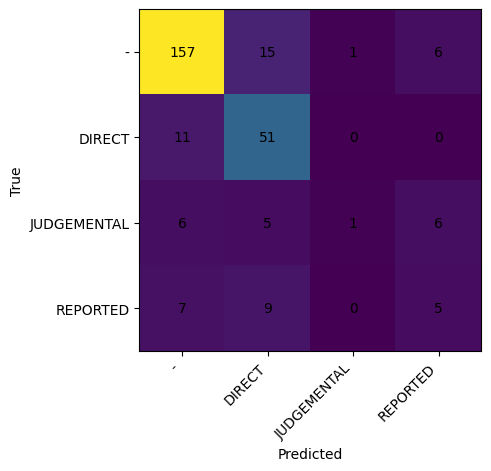


=== Sample misclassified TEST tweets (Twitter-roBERTa, seed=2024) ===


,tweet,clean_lemma,label,label_id,pred_label_id,pred_label
5,"“I mean I do, but… wouldn’t it be fun to get g...","i mean i do , but ... would not it be fun to g...",-,0,1,DIRECT
8,@BBCYaldaHakim Kabul: Islamic Emirate of Afgha...,kabul islamic emirate of afghanistan have anno...,REPORTED,3,0,-
9,Appreciate being included along with @wphillip...,appreciate be include along with on the uvalde...,-,0,3,REPORTED
13,"""The violent antifeminism of a far-right movem...",the violent antifeminism of a far right moveme...,REPORTED,3,0,-
14,@MrsGreyBull @Miriam2626 Ah! Look! Gender role...,"ah ! look ! gender role be back , too ! the do...",DIRECT,1,0,-
21,@Catoishere @HatClub @RahnniFitteds That gold ...,that gold digger be nice but the picture and s...,DIRECT,1,0,-
22,He Tries To Expose This Gold Digger BUT IT BAC...,he try to expose this gold digger but it backf...,-,0,1,DIRECT
23,@MatrixPirate12 Well let me ask for the guys… ...,well let i ask for the guy ... do you ever jus...,-,0,1,DIRECT
28,Dear @starwars fans Can we not harass talented...,dear fan can we not harass talented actor of c...,JUDGEMENTAL,2,0,-
50,@DaddyBrianMC @roadhouse2100 @stlcty03 Not as ...,not as much as they harm kill woman and child ...,DIRECT,1,0,-


In [ ]:
# --- Select predictions for BEST_SEED on TEST set ---
y_test_best = test_preds_by_seed[BEST_SEED]["y_true"]
y_pred_test_best = test_preds_by_seed[BEST_SEED]["y_pred"]

df_rep_test_roberta, cm_test_roberta = evaluate_predictions(
    y_true=y_test_best,
    y_pred=y_pred_test_best,
    labels_map=id2label,
)

print(f"=== Twitter-roBERTa (seed={BEST_SEED}) – Test classification report ===")
display(df_rep_test_roberta)

print(f"\n=== Twitter-roBERTa (seed={BEST_SEED}) – Test confusion matrix ===")
plot_confusion_matrix(
    cm_test_roberta,
    labels=[id2label[i] for i in sorted(id2label.keys())],
)

mis_idx_test = np.where(y_test_best != y_pred_test_best)[0]

df_errors_test_roberta = df_test_hf.iloc[mis_idx_test][
    ["tweet", "clean_lemma", "label", "label_id"]
].copy()
df_errors_test_roberta["pred_label_id"] = y_pred_test_best[mis_idx_test]
df_errors_test_roberta["pred_label"] = df_errors_test_roberta["pred_label_id"].map(id2label)

print(f"\n=== Sample misclassified TEST tweets (Twitter-roBERTa, seed={BEST_SEED}) ===")
df_errors_test_roberta.head(20)
